In [1107]:
import numpy as np
import matplotlib.pyplot as plt
import random

We are doing Bayesian Optimization!! This will try and "predict" a function based on observations. The way this prediction works is it uses a multivariate Gaussian distribution, with every dimension corresponding to an $x$ value. Since there are infinite $x$, it should have infinite dimensions. We predict our function by taking the mean of the distribution, and we find the covariance by using a kernel (which we will define later). The diagonals of the covariance matrix give us the variance along every dimension (x-value) so that we can output a lower confidence bound (LCB) and upper confidence bound (UCB). 

Before we write our script, we define a function to minimize, namely

$$ f(x) = \frac{1}{4}x^4 + \frac{2}{3}x^3 - \frac{1}{2}x^2 -2x + 1 $$

This function has a global min at $x=1$ and a local min at $x=-2$. Usually in Bayesian Optimization, we don't get to see our function.

In [1108]:
f = lambda x: 1/4 * x**4 + 2/3 * x**3 - 1/2 * x**2 - 2 * x**1 + 1

Next, we set a range for values that we will examine $f(x)$ for. In our case, let's examine $f(x)$ in the range $[-3,2]$.

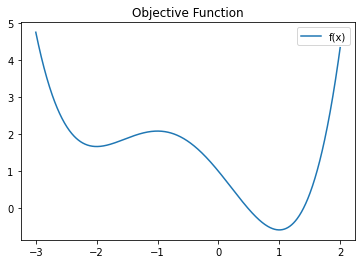

In [1109]:
x_vals = np.linspace(-3,2,1000)
y = [f(x) for x in x_vals]
plt.plot(x_vals,y, label = 'f(x)')
plt.legend()
plt.title('Objective Function')
plt.show()

Now, we need to set up our parameters for Bayesian optimization. We will use scikit-learn to implement our kernel for us. There are also additional parameters that we can modify. 

In [1110]:
from numpy import argmax, argmin
from scipy.stats import norm

eps = 0.5

def PI(mean, std, current_best):
    out = norm.cdf((current_best - eps - mean) / std)
    if max(out) < 5e-10:
        return None
    return out

def EI(mean, std, current_best):
    out = 0
    if max(out) < 1e-5:
        return None
    return out

In [1111]:
def obj(X):
    out = []
    if type(X) == list:
        for x_val in X:
            out.append(f(x_val))
    else:
        return f(X)
    return out

In [1112]:
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

params = {
    'num_init': 5,                      # defines how many initial points we use to sample the function
    'num_calls': 40,                    # defines how many function calls we are allowed to use
    'num_samples': 1000,                # defines how many random points we sample to choose our point for the next iteration of BO

    'x_min': -3,                        
    'x_max': 2,
    'objective': obj,
    'kernel': Matern(),         # defines our Covariance function for BO
    'acquisition_function': PI,       # acquisition function can be one of EI (exp improvement), PI (prob improvement), LCB (lower conf bound), gp_hedge
}

We are now ready to implement Bayesian optimization! Functions below will be used to run BO on our function. The main function is optimize(), which actually runs the optimization. The other functions are supporting functions that are 

In [1113]:
class BayesianOptimizer:
    def __init__(self, params):
        # user-defined parameters
        self.x_min = params['x_min']
        self.x_max = params['x_max']
        self.objective = params['objective']
        self.kernel = params['kernel']
        self.acquisition_function = params['acquisition_function']
        self.num_init = params['num_init']
        self.num_samples = params['num_samples']
        self.num_calls = params['num_calls']
        self.current_best = 1e20 #initialize to +infty
        self.cur_iter = 0
        self.next_x = self.x_min

        # empty data structures
        self.x_train = []             # history of all selected x values
        self.y_train = []             # discovered y-values for selected x values
        self.model = GaussianProcessRegressor(normalize_y = True, kernel=self.kernel, alpha=1e-5, optimizer=None)
        self.best_y_per_iter = []



    def optimize(self):
        init_points = np.linspace(self.x_min, self.x_max, self.num_init)
        for x in init_points:
            self.observe(x)
        while self.next_x and self.cur_iter < self.num_calls: #while we have not converged and not reached our compute limit
            self.select_next()
            self.observe(self.next_x)
        print(self.x_train)
        return self.current_best
    


    def observe(self, x):
        '''
        Observes the point by calling the function
        '''
        if x == None:
            return
        y = self.objective(x)
        self.x_train.append([x]) 
        self.y_train.append([y])
        self.current_best = min(self.current_best, y)
        self.best_y_per_iter.append(self.current_best)
        self.model.fit(self.x_train, self.y_train)
        self.cur_iter += 1
        self.plot()



    def select_next(self):
        sampled_x = np.random.uniform(self.x_min, self.x_max, self.num_samples) # we sample n random points in [x_min, x_max]
        mu, std = self.model.predict(np.reshape(sampled_x, (self.num_samples,1)), return_std=True)      # for each point, we find the distribution along that dimension
        acq = self.acquisition_function(mu, std, self.current_best)
        if acq is None:
            self.next_x = None
            print('acq = ', acq)
        else:
            self.next_x = sampled_x[argmax(acq)]           # we take the point that has the best chance of improvement   
    


    def plot(self):
        onedim_X = np.linspace(self.x_min, self.x_max, 10000)
        y = self.objective(onedim_X)
        X = [[x] for x in onedim_X]
        mu, std = self.model.predict(X, return_std=True)

        plt.plot(X, y, color="purple", linewidth = 2)
        plt.plot(X, mu, color="black", linewidth = 2)
        plt.plot(X, mu + std, color="black", linewidth = 1)
        plt.plot(X, mu - std, color="black", linewidth = 1)
        plt.plot(X, mu + 2*std, color="black", linewidth = 1, alpha=0.3)
        plt.plot(X, mu - 2*std, color="black", linewidth = 1, alpha=0.3)
        plt.plot(X, mu + 3*std, color="black", linewidth = 1, alpha=0.3)
        plt.plot(X, mu - 3*std, color="black", linewidth = 1, alpha=0.3)
        plt.axhline(self.current_best - eps, color='r')
        plt.fill_between(onedim_X, mu - std, mu + std, color="black", alpha=0.2)
        plt.fill_between(onedim_X, mu - 2*std, mu + 2*std, color="black", alpha=0.1)
        plt.fill_between(onedim_X, mu - 3*std, mu + 3*std, color="black", alpha=0.05)
        plt.scatter(self.x_train, self.y_train, color="purple")
        plt.show()


In [1114]:
bo = BayesianOptimizer(params)

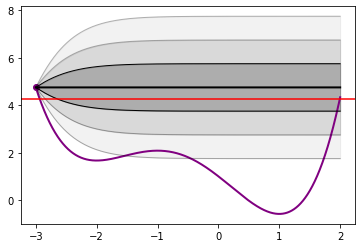

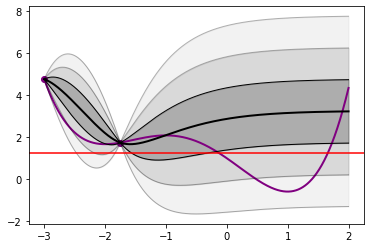

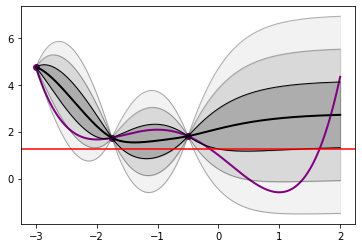

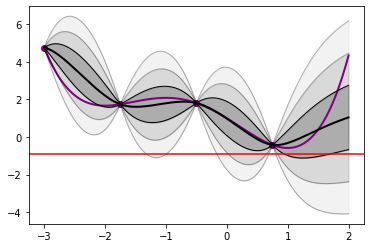

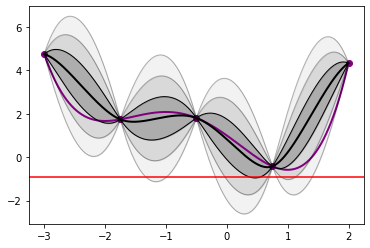

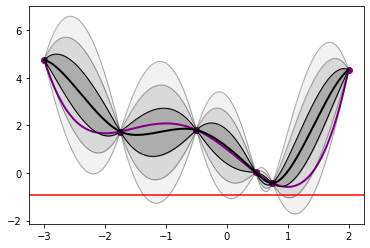

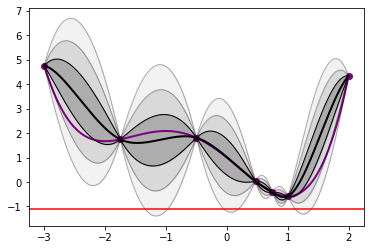

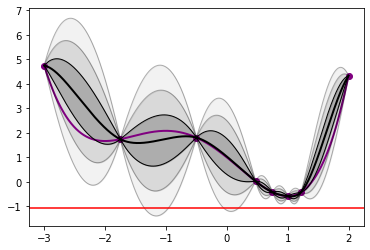

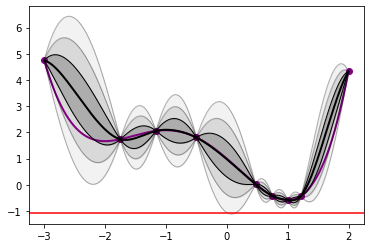

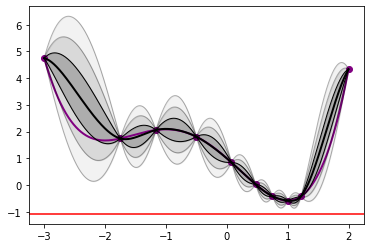

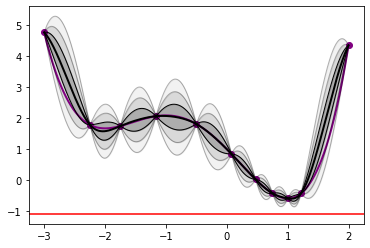

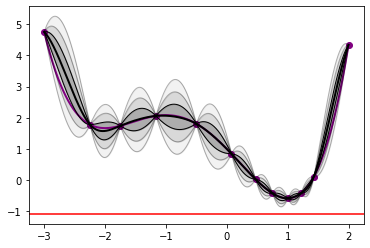

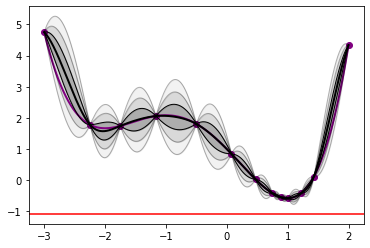

acq =  None
[[-3.0], [-1.75], [-0.5], [0.75], [2.0], [0.4721687883209422], [1.003090539125985], [1.2189497369499502], [-1.1637847188950607], [0.07699226972061535], [-2.2479511679784725], [1.4284881756490435], [0.8838868069926722]]


-0.5833046298158004

In [1115]:
bo.optimize()

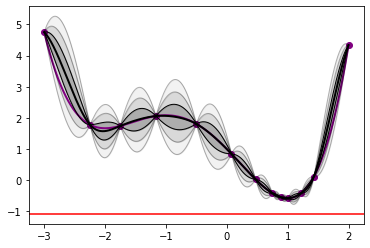

In [1116]:
bo.plot()

In [1117]:
'''import matplotlib.animation as animation
from IPython import display

fig = plt.figure()

X = np.linspace(bo.x_min, bo.x_max, 1000)
y = bo.objective(X)
orig_func = plt.plot(X, y)

mu_plots, = plt.plot(X, y)
std_plots, = plt.plot(X, y)
plus_plots, = plt.plot(X, y)                 # mean + 1 std
minus_plots, = plt.plot(X, y)                # mean - 1 std
#training_data_scatter = plt.scatter(x=None, y=None)

def update(frame):
    mu = bo.mus[frame]
    std = bo.stds[frame]
    plus = mu + std
    minus = mu - std
    x_train = bo.x_train[:frame]
    y_train = bo.y_train[:frame]

    mu_plots.set_ydata((X, mu))
    std_plots.set_data(X, std)
    plus_plots.set_data(X, plus)
    minus_plots.set_data(X, minus)
    #training_data_scatter.set_data(x_train, y_train)

    x= (orig_func, mu_plots, std_plots, plus_plots, minus_plots)#, training_data_scatter)
    print(x)
    return x

print(bo.stds)

print(len(bo.stds))

ani = animation.FuncAnimation(fig=fig, func=update, frames=params['num_calls'], interval=30, )
plt.show()
'''

    

"import matplotlib.animation as animation\nfrom IPython import display\n\nfig = plt.figure()\n\nX = np.linspace(bo.x_min, bo.x_max, 1000)\ny = bo.objective(X)\norig_func = plt.plot(X, y)\n\nmu_plots, = plt.plot(X, y)\nstd_plots, = plt.plot(X, y)\nplus_plots, = plt.plot(X, y)                 # mean + 1 std\nminus_plots, = plt.plot(X, y)                # mean - 1 std\n#training_data_scatter = plt.scatter(x=None, y=None)\n\ndef update(frame):\n    mu = bo.mus[frame]\n    std = bo.stds[frame]\n    plus = mu + std\n    minus = mu - std\n    x_train = bo.x_train[:frame]\n    y_train = bo.y_train[:frame]\n\n    mu_plots.set_ydata((X, mu))\n    std_plots.set_data(X, std)\n    plus_plots.set_data(X, plus)\n    minus_plots.set_data(X, minus)\n    #training_data_scatter.set_data(x_train, y_train)\n\n    x= (orig_func, mu_plots, std_plots, plus_plots, minus_plots)#, training_data_scatter)\n    print(x)\n    return x\n\nprint(bo.stds)\n\nprint(len(bo.stds))\n\nani = animation.FuncAnimation(fig=fig,

Here is how the minimum changes over each iteration. 

[4.75, 1.7405598958333335, 1.7405598958333335, -0.4208984375, -0.4208984375, -0.4208984375, -0.5833046298158004, -0.5833046298158004, -0.5833046298158004, -0.5833046298158004, -0.5833046298158004, -0.5833046298158004, -0.5833046298158004]


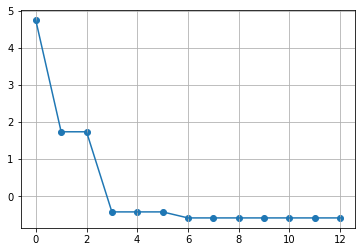

In [1118]:
print(bo.best_y_per_iter)
data = bo.best_y_per_iter
x = list(range(len(data)))

plt.plot(x, data)
plt.scatter(x, data)
plt.grid()
plt.show()

And finally, we write a class for random search to see if Bayesian Optimization outperforms basic random search. The class definition is below:

In [1119]:
class RandomSearch():
    def __init__(self,params):
        self.num_calls = params['num_calls']
        self.objective = params['objective']
        self.x_min = params['x_min']
        self.x_max = params['x_max']

        self.best_y = 1e20
        self.best_y_per_iter = []

    def optimize(self):
        for iter in range(self.num_calls):
            next_x = self.select_next()
            self.observe(next_x)

    def select_next(self):
        return np.random.uniform(self.x_min, self.x_max)

    def observe(self, x):
        y = self.objective(x)
        self.best_y = min(self.best_y, y)
        self.best_y_per_iter.append(self.best_y)

In [1120]:
random = RandomSearch(params)
random.optimize()

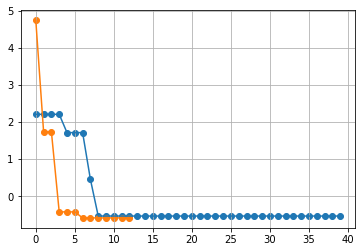

In [1122]:
rand_data = random.best_y_per_iter
rand_x = list(range(len(rand_data)))

plt.plot(rand_x, rand_data)
plt.plot(x, data)
plt.scatter(rand_x, rand_data)
plt.scatter(x, data)
plt.grid()
plt.show()